In [95]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# change to False, if you are not using dark mode
dark_mode = True

# adapts matplotlib color settings to work with dark mode
if dark_mode:
    plt.rcParams['text.color'] = 'white'
    plt.rcParams['axes.labelcolor'] = 'white' 
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['legend.facecolor'] = 'black'

# The Izhikevich Neuron

<br/>

The Izhikevich neuron is a mathematical model that can reproduce the spiking behavior of various different neuron types in the brain.
It is a two-dimensional model with two state variables - the membrane potential $v$ and a recovery variable $u$ that lumps the effects of passive membrane currents and spike-triggered adaptation currents.
The dynamics of those two variables are given by

$$C \dot v = k (v - v_r)(v - v_{\theta}) - u + I(t) + g s_{in} (E-v),$$
$$\tau_u \dot u = -u + b (v - v_r) + \tau_u \kappa s.$$

The parameters controlling the behavior of the Izhikevich neuron are the following:

- $C$ - the capacitance of the cell membrane (unit: pF)
- $k$ - a lumped parameter that controls the leak current dynamics of the cell (unit: nS/mV)
- $v_r$ - the resting membrane potential (unit: mV)
- $v_t$ - the threshold potential at which the cell starts to initiate a spike (unit: mV)
- $I(t)$ - any extrinsic current (unit: pA)
- $g$ - conductance of a synapse type (unit: nS)
- $E$ - reversal potential of a synapse type (unit: mV)
- $\tau_u$ - time constant of the recovery variable (unit: ms)
- $b$ - conductance for lumped recovery variable (unit: nS)
- $\kappa$ - strength of spike-frequency adaptation currents (unit: pA)
- $s_{in}$ - incoming synaptic input, i.e. spike trains (unit: dimensionless)

Finally, the neuron can spike, generating a spike train $s$, which is defined as 

$s = \sum_{k \backslash t_k \leq t} \delta(t-t_k),$

where $t_k$ are the spike times of the neuron.
The neuron is said to spike when its membrane potential $v$ crosses a peak value $v_{peak}$, after which $v$ is reset to a reset value $v_{reset}$.

<br/>

You might encounter a version of the Izhikevich neuron that contains slightly different equations and parameters. That is the dimensionless version of the Izhikevich neuron model, where the state variables have been re-scaled into a dimensionless form (follow [this link](https://izhikevich.org/publications/spikes.htm) for an introductory paper on the dimensionless Izhikevich neuron).


## Dynamic Regimes of the Izhikevich Neuron

<br/>

Depending on the choice of parameters, the Izhikevich neuron can produce a rich set of dynamic regimes, including regimes such as quiescent, regular firing, bursting, or resonating.

<br/>

Below, we will use numerical integration of the Izhikevich neuron equations to explore some of the parameter dependencies of the Izhikevich neuron.

### (I) Transitions Between Quiescent and Regular Firing Regimes

<br/>

The code cell below defines an Izhikevic neuron in a quiescent regime, that can be pushed into a regular firing regime via increases in its input.
We would like to run simulations of the neuron dynamics and explore how they change as we change the parameters of the neuron.

<br/>

For this purpose, a [RectiPy](https://github.com/pyrates-neuroscience/RectiPy) network instance is created in the cell below, in which a single Izhikevich neuron is placed. 

Execute the cell, try to understand what the different code blocks do, and move on.

In [45]:
from rectipy import Network

# initialize a network instance 
dt = 1e-2
v_reset = -1e2
v_peak = 1e2
rs = Network(dt=dt, device="cpu")

# define IK neuron with regular spiking parameters
node = "neuron_model_templates.spiking_neurons.ik.ik"
rs_params={"C": 100.0, "k": 0.7, "v_r": -60.0, "v_theta": -40.0, "b": -2.0, "g": 15.0,
           "tau_u": 33.33, "kappa": 10.0, "tau_s": 6.0, "E_r": 0.0, "eta": 0.0}

# add a single IK neuron to the network
rs.add_diffeq_node("ik", node, weights=np.zeros((1, 1)), source_var="s", 
                   target_var="s_in", input_var="I_ext", output_var="v",
                   spike_var="spike", spike_def="v", op="ik_op", spike_reset=v_reset,
                   spike_threshold=v_peak, node_vars=rs_params
                  )

# save initial state for later
y0 = rs.state

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.


In the cell below, we perform a numerical simulation of the response of a single Izhikevich neuron to a current ramp.
In other words, we solve the [initial value problem (IVP)](http://www.scholarpedia.org/article/Initial_value_problems) for the Izhikevich neuron equations, given the parameters specified in the above cell.
We solve the IVP numerically via the [forward Euler method](https://en.wikipedia.org/wiki/Euler_method) with an integration step-size of $dt$ (defined in the code cell above).

<br/>

Execute the next two cells to (i) perform the simulation, and (ii) plot the resulting dynamics. 
Feel free to play around with the parameters of the simulation and input, i.e. the simulation duration, or the input strength.

In [46]:
# input parameters (feel free to change these)
simulation_steps = 50000
min_input_current = 0
max_input_current = 500

# define an input current ramp
time = np.arange(0, simulation_steps) * dt
inp = np.zeros((steps, 1))
inp[:, 0] = np.linspace(min_input_current, max_input_current, steps)

# run the numerical simulation for the input ramp
sr = 10
rs.reset(y0)
obs = rs.run(inputs=inp, sampling_steps=sr, verbose=False)

Text(0.5, 0, 'simulation step')

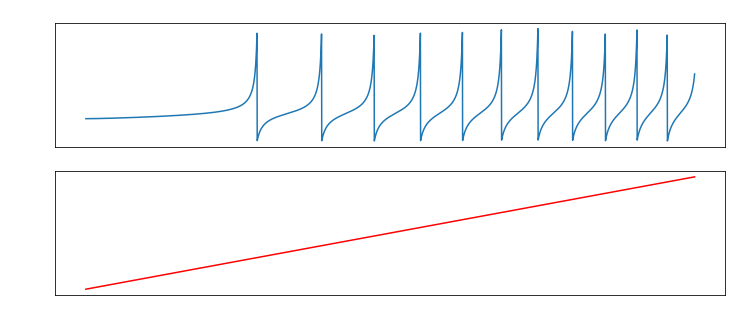

In [34]:
_, axes = plt.subplots(nrows=2, figsize=(12, 5))

# plot the membrane potential 
obs.plot("out", ax=axes[0])
axes[0].set_ylabel("v")
axes[0].set_xlabel("sample")
axes[0].set_title("Regular Spiking Neuron")

# plot the current ramp
axes[1].plot(inp[:, 0], color="red")
axes[1].set_ylabel("I_ext")
axes[1].set_xlabel("simulation step")
plt.tight_layout()

As you can see from these simulations, the neuron is in a quiescent regime for $I_{ext} = 0.0$ pA and starts to elicit spikes for $I_{ext} \approx 80$ pA, after which the spiking frequency increases with the square root of the input strength.
When the neuron transitions from quiescent to regular firing dynamics, it has undergone a [saddle-node-on-invariant-circle (SNIC) bifurcation](http://www.scholarpedia.org/article/Ermentrout-Kopell_canonical_model).
Below, we depicted the SNIC bifurcation again in the membrane potential variable $v$ for changes in the input $I$:

<img src="img/snic.png" width="800">

The cell below allows you to change the spike-frequency adaptation strength of the neuron from $\kappa = 10$ pA to $\kappa = 200$ pA. 
Notice how this changes the spike frequency of the neuron in response to the input.

<br/>

Feel free to play around with this code cell and introduce other parameter changes to the model.

Text(0.5, 0, 'simulation step')

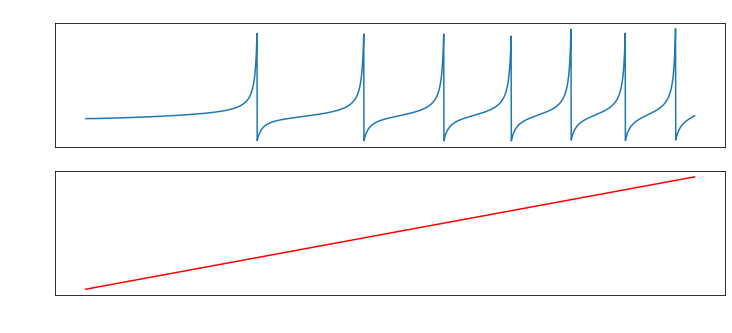

In [36]:
# change model parameter (feel free to play around with this)
kappa = 200.0
rs.set_var("ik", "ik_op/kappa", kappa)

# run the numerical simulation again
rs.reset(y0)
obs = rs.run(inputs=inp, sampling_steps=sr, verbose=False)

# plot the results
_, axes = plt.subplots(nrows=2, figsize=(12, 5))
obs.plot("out", ax=axes[0])
axes[0].set_ylabel("v")
axes[0].set_xlabel("sample")
axes[0].set_title(f"Regular Spiking Neuron (kappa = {kappa})")
axes[1].plot(inp[:, 0], color="red")
axes[1].set_ylabel("I_ext")
axes[1].set_xlabel("simulation step")
plt.tight_layout()

### (II) Transitions Between Quiescent and Bursting Regimes

<br/>

To show how the intrinsic parameters of the Izhikevich neuron can drastically change its dynamics, we will now consider so-called [chattering neurons](https://izhikevich.org/publications/spikes.htm). 
Instead of responding to input with spikes elicited at regular inter-spike intervals, chattering neurons respond with bursts that have an intra-burst frequency and an inter-burst frequency.

<br/>

In the cell below, we will explore the response of this neuron type to an input ramp again. 
In order to get an intuition for how these different dynamics come about, compare the model parameters that we used for the regular-spiking neuron above with the parameters of the chattering neuron below.

In [50]:
# initialize a network instance 
v_reset = -40.0
v_peak = 1e2
ch = Network(dt=dt, device="cpu")

# define IK neuron
node = "neuron_model_templates.spiking_neurons.ik.ik"
ch_params={"C": 50.0, "k": 1.5, "v_r": -60.0, "v_theta": -40.0, "b": 1.0, "g": 15.0,
           "tau_u": 33.33, "kappa": 150.0, "tau_s": 6.0, "E_r": 0.0, "eta": 0.0}

# add a single IK neuron to the network
ch.add_diffeq_node("ik", node, weights=np.zeros((1, 1)), source_var="s", 
                   target_var="s_in", input_var="I_ext", output_var="v",
                   spike_var="spike", spike_def="v", op="ik_op", spike_reset=v_reset,
                   spike_threshold=v_peak, node_vars=ch_params
                  )

# save initial state for later
y0 = ch.state

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.


Text(0.5, 0, 'simulation step')

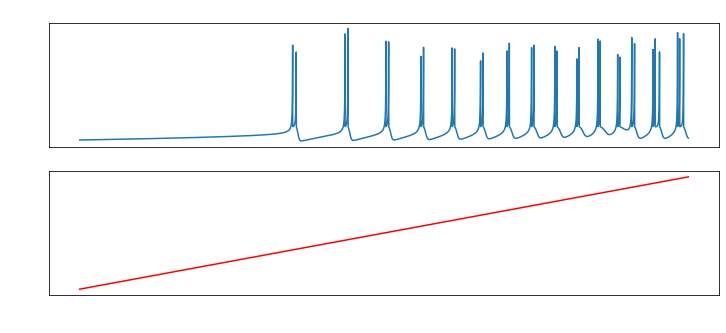

In [51]:
# run the numerical simulation again
ch.reset(y0)
obs = ch.run(inputs=inp, sampling_steps=sr, verbose=False)

# plot the results
_, axes = plt.subplots(nrows=2, figsize=(12, 5))
obs.plot("out", ax=axes[0])
axes[0].set_ylabel("v")
axes[0].set_xlabel("sample")
axes[0].set_title("Chattering Neuron")
axes[1].plot(inp[:, 0], color="red")
axes[1].set_ylabel("I_ext")
axes[1].set_xlabel("simulation step")
plt.tight_layout()

The most important differences between regular-spiking and chattering neurons are:

- The differences in the parameters $b$ and $k$ that control the dependence of the neural dynamics on its current state of excitation/inhibition
- Chattering neurons are reset to their spike threshold value $v_t$ after spiking, so that small inputs can trigger an immediate second/third spike. Resting neurons are reset to a potential below their resting potential. They are thus always refractory after a spike.

<br/>

### (III) Exploration 

<br/>

Now that you have obtained an intuition for how changes in the model parameters translate to changes in its spiking dynamics, feel free to play around with other model parameters, inputs, etc.:

Text(0.5, 0, 'simulation step')

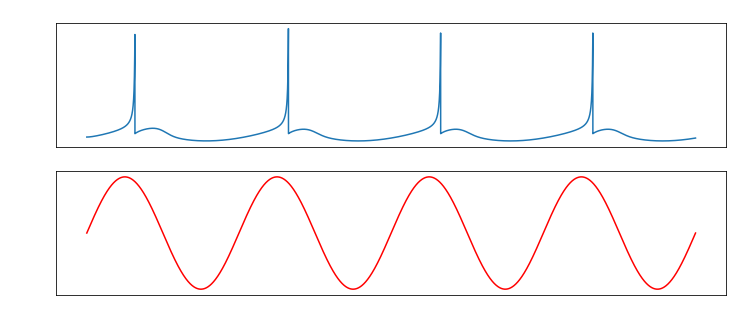

In [42]:
# initialize a network instance (feel free to change peak and reset potential)
v_reset = -55.0
v_peak = 1e2
ik = Network(dt=dt, device="cpu")

# define IK neuron
node = "neuron_model_templates.spiking_neurons.ik.ik"
ik_params={"C": 100.0, "k": 1.2, "v_r": -75.0, "v_theta": -45.0, "b": 5.0, "g": 15.0,
           "tau_u": 33.33, "kappa": 20.0, "tau_s": 6.0, "E_r": 0.0, "eta": 0.0}

# add a single IK neuron to the network
ik.add_diffeq_node("ik", node, weights=np.zeros((1, 1)), source_var="s", 
                   target_var="s_in", input_var="I_ext", output_var="v",
                   spike_var="spike", spike_def="v", op="ik_op", spike_reset=v_reset,
                   spike_threshold=v_peak, node_vars=ik_params
                  )

# define a different input (example below defines a sinusoidal input)
steps = 100000
time = np.arange(0, steps)*dt
inp = np.zeros((steps, 1))
freq, amp = 4.0, 100.0
inp[:, 0] = np.sin(time*2.0*np.pi*freq*1e-3) * amp

# run the numerical simulation again
obs = ik.run(inputs=inp, sampling_steps=sr, verbose=False)

# plot the results
_, axes = plt.subplots(nrows=2, figsize=(12, 5))
obs.plot("out", ax=axes[0])
axes[0].set_ylabel("v")
axes[0].set_xlabel("sample")
axes[0].set_title("Membrane potential dynamics")
axes[1].plot(inp[:, 0], color="red")
axes[1].set_ylabel("I_ext")
axes[1].set_xlabel("simulation step")
axes[1].set_title("Input dynamics")
plt.tight_layout()

# Networks of Coupled IK Neurons

<br/>

Now that we have examined some of the different dynamics that a single IK neuron can express, let's move on to networks of coupled IK neurons.
Specifically, we are interested in [emergent phenomena](https://en.wikipedia.org/wiki/Emergence), i.e. behaviors that arise from the interactions of many neurons and that cannot be explained by the dynamics of the isolated neurons.

<br/>

Which dynamic regimes can we observe in a neural network with a certain network structure? And how could those dynamics help to implement brain function?
These are questions at the heart of network neuroscience and the models/methods introduced in this tutorial are crucial ingredients for adressing these questions. 

## Mean-field Variables of Network Dynamics

<br/>

To examine different dynamic regimes of neural networks, 
we will look at dynamics of networks of IK neurons.
Global variables such as the average firing rate or the average membrane potential across all neurons in the network contain important information about the dynamic regime of the system.

<img src="img/micro.png" width="800">

Let's examine how the response of neural networks to extrinsic inputs changes when we change key parameters of the system.  

### (I) Transitions between quiescent and persistent states of neural activity 

<br/>

Let's create a network of $N = 200$ regular-spiking neurons with random coupling.
To account for the diversity of neurons in any part of the brain, let's make each neuron in the network slightly different from the other, by choosing distinct spike thresholds $v_t$ for each neuron.

<br/>

In the cell below, we define a simple function for drawing spike thresholds from a [Lorentzian distribution](https://en.wikipedia.org/wiki/Cauchy_distribution).

In [58]:
from scipy.stats import cauchy

def lorentzian(n: int, mu: float, delta: float, lb: float, ub: float):
    samples = np.zeros((n,))
    for i in range(n):
        s = cauchy.rvs(loc=mu, scale=delta)
        while s <= lb or s >= ub:
            s = cauchy.rvs(loc=mu, scale=delta)
        samples[i] = s
    return samples

Now, we can use the tools from RectiPy to define the network.
Note how the syntax barely differs from what we already used above for single neuron networks.

In [84]:
from rectipy import Network, random_connectivity

# initialize a network instance 
dt = 1e-2
sr = 100
v_reset = -1e2
v_cutoff = 1e2
ik = Network(dt=dt, device="cpu")

# define IK neurons
N = 200
node = "neuron_model_templates.spiking_neurons.ik.ik"
Delta_v = 2.0
v_t = -40.0
v_r = -60.0
v_thetas = lorentzian(N, mu=v_t, delta=Delta_v, lb=v_r, ub=2 * v_t - v_r)
ik_params={"C": 100.0, "k": 0.7, "v_r": v_r, "v_theta": v_thetas, "b": -2.0, "g": 15.0,
           "tau_u": 33.33, "kappa": 10.0, "tau_s": 6.0, "E_r": 0.0, "eta": 0.0}

# define network connectivity
p = 0.2
W = random_connectivity(N, N, p, normalize=True)

# add population of coupled IK neurons to the network
ik.add_diffeq_node("ik", node, weights=W, source_var="s", target_var="s_in", 
                   input_var="I_ext", output_var="v", spike_var="spike", 
                   spike_def="v", op="ik_op", spike_reset=v_reset,
                   spike_threshold=v_cutoff, node_vars=ik_params
                  )

# save initial state for resetting
y0 = ik.state

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.


Next, let's again define an input ramp and study how the network response to the input.

In [90]:
# define extrinsic input
steps = 100000
time = np.arange(0, steps) * dt
inp = np.zeros((steps, 1))
I_ext = np.linspace(-10, 80, steps)
inp[:, 0] = I_ext 

# run simulation
ik.reset(y0)
obs = ik.run(inputs=inp, sampling_steps=sr, verbose=False)

Execute the cell below to visualize the resulting dynamics.

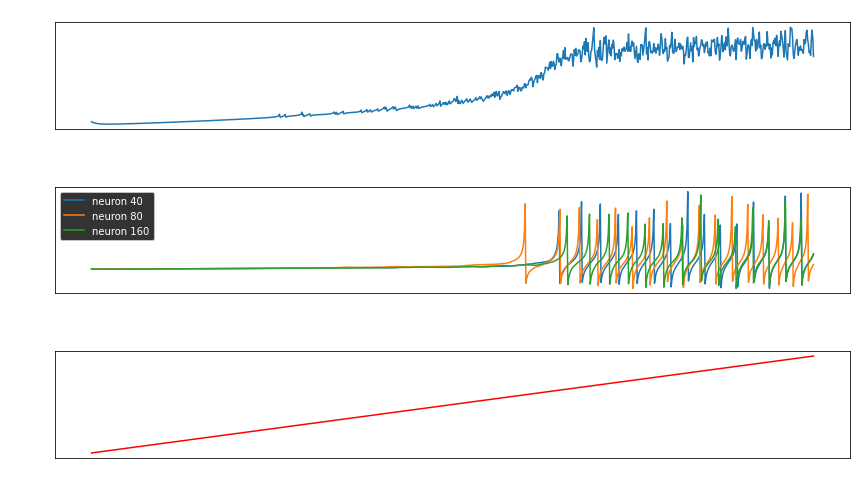

In [91]:
_, axes = plt.subplots(nrows=3, figsize=(12, 7))

# plot average membrane potential
v = obs.to_dataframe("out")
ax = axes[0]
ax.plot(v.mean(axis=1))
ax.set_ylabel("mean(v)")
ax.set_xlabel("sample")
ax.set_title("Average membrane potential dynamics in the network")

# plot spiking activity of example neurons
examples = [40, 80, 160]
ax = axes[1]
for ex in examples:
    ax.plot(v.iloc[:, ex], label=f"neuron {ex}")
ax.set_ylabel("v")
ax.set_xlabel("sample")
ax.set_title("Membrane potential dynamics of exemplary neurons")
ax.legend()

# plot input
ax = axes[2]
ax.plot(inp[:, 0], color="red")
ax.set_ylabel("I_ext")
ax.set_xlabel("simulation step")
plt.tight_layout()

It seems like the network undergoes a rapid transition from a quiescent state into a state of persistent firing activity at around $I_{ext} \approx 45$ pA.
Let's see how the network behaves if we slowly decrease the input back to its initial value of $I_{ext} = 10$ pA.

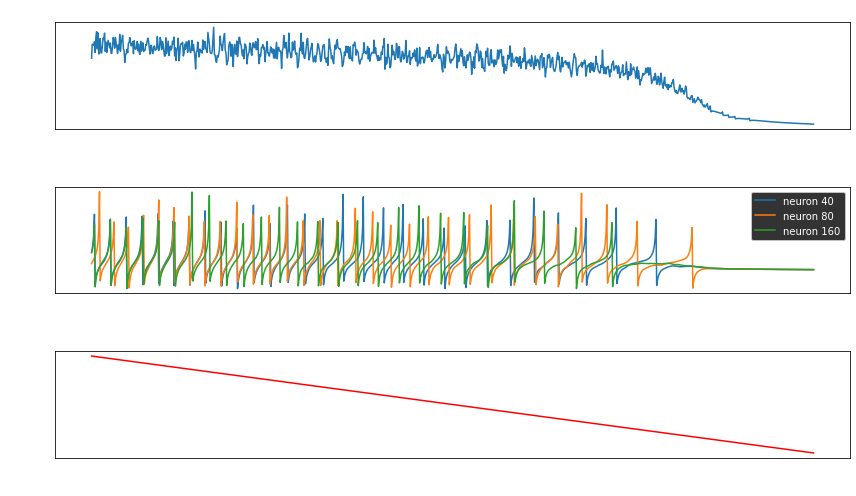

In [92]:
# run the simulation with reversed input
obs2 = ik.run(inputs=inp[::-1].copy(), sampling_steps=sr, verbose=False)

# plot the results
_, axes = plt.subplots(nrows=3, figsize=(12, 7))

v = obs2.to_dataframe("out")
ax = axes[0]
ax.plot(v.mean(axis=1))
ax.set_ylabel("mean(v)")
ax.set_xlabel("sample")
ax.set_title("Average membrane potential dynamics in the network")

examples = [40, 80, 160]
ax = axes[1]
for ex in examples:
    ax.plot(v.iloc[:, ex], label=f"neuron {ex}")
ax.set_ylabel("v")
ax.set_xlabel("sample")
ax.set_title("Membrane potential dynamics of exemplary neurons")
ax.legend()

ax = axes[2]
ax.plot(inp[::-1, 0], color="red")
ax.set_ylabel("I_ext")
ax.set_xlabel("simulation step")
plt.tight_layout()

Interestingly, we do not observe a transition back to the quiescent state at around $I_{ext} \approx 45$ pA, but at a much lower value of $I_{ext} \approx 15$ pA.
This suggests, that there exist multiple stable states in the parameter regime $15 < I_{ext} < 45$ pA.
A bifurcation diagram for this behavior is depicted below.

<br/>

When the system is in the quiescent regime, it has to be pushed beyond the [fold bifurcation](http://www.scholarpedia.org/article/Saddle-node_bifurcation) at $I_{ext} \approx 45$ pA to transition into the persistent activity regime.
But once it is in the persistent activity regime, is has to be pushed below the fold bifurcation at $I_{ext} \approx 15$ pA to transition back into the quiescent regime.

<br/>

This bi-stability (also called [hysteresis](https://en.wikipedia.org/wiki/Hysteresis))is an emergent phenomenon. It does not exist in the isolated regular-spiking neuron and thus emerges from the interactions between neurons.
Bi-stable regimes like this provide a form of network memory and have been used in models of working memory.

### (II) Transitions Between Asynchronous and Synchronous Regimes

<br/>

Above, we have found out that changes in the spike-frequency adaptation strength $\kappa$ altered the response of a single neuron to a current ramp.
For the neural network that we studied in the previous section, we chose spike-frequency adaptation to be small ($\kappa = 10$ pA). 
Let's see how a neural network with strong spike-frequency adaptation responds to such a current ramp. 

In [93]:
# change the strength of spike-frequency adaptation
ik.set_var("ik", "ik_op/kappa", 200.0)

# run the simulation with the same current ramp
ik.reset(y0)
obs3 = ik.run(inputs=inp, sampling_steps=sr, verbose=False)

# plot the results
_, axes = plt.subplots(nrows=3, figsize=(12, 7))

v = obs3.to_dataframe("out")
ax = axes[0]
ax.plot(v.mean(axis=1))
ax.set_ylabel("mean(v)")
ax.set_xlabel("sample")
ax.set_title("Average membrane potential dynamics in the network")

examples = [40, 80, 160]
ax = axes[1]
for ex in examples:
    ax.plot(v.iloc[:, ex], label=f"neuron {ex}")
ax.set_ylabel("v")
ax.set_xlabel("sample")
ax.set_title("Membrane potential dynamics of exemplary neurons")
ax.legend()

ax = axes[2]
ax.plot(inp[::-1, 0], color="red")
ax.set_ylabel("I_ext")
ax.set_xlabel("simulation step")
plt.tight_layout()

It seems like the network transitions into a regime of synchronous firing, if extrinsic stimulation and spike-frequency adaptation are sufficiently strong.
This is very different from what we observed before.
It must mean that either the fold bifurcations vanished, or at least moved in parameter space, and that a [Hopf bifurcation](http://www.scholarpedia.org/article/Andronov-Hopf_bifurcation) jumped into existence that we pushed the system over via our current ramp.  
Clearly, spike-frequency adaptation strength is an important control variable of the network dynamics.

<br/>

### (III) Exploration

<br/>

Below, we provide code cells that allow you to play around with the network parameters and input parameters and try out different parameter regimes yourself.

In [ ]:
# initialize a network instance 
dt = 1e-2
sr = 100
v_reset = -1e2
v_cutoff = 1e2
ik = Network(dt=dt, device="cpu")

# define IK neurons
N = 200
node = "neuron_model_templates.spiking_neurons.ik.ik"
Delta_v = 2.0
v_t = -40.0
v_r = -60.0
v_thetas = lorentzian(N, mu=v_t, delta=Delta_v, lb=v_r, ub=2 * v_t - v_r)
ik_params={"C": 100.0, "k": 0.7, "v_r": v_r, "v_theta": v_thetas, "b": -2.0, "g": 15.0,
           "tau_u": 33.33, "kappa": 10.0, "tau_s": 6.0, "E_r": 0.0, "eta": 0.0}

# define network connectivity
p = 0.2
W = random_connectivity(N, N, p, normalize=True)

# add population of coupled IK neurons to the network
ik.add_diffeq_node("ik", node, weights=W, source_var="s", target_var="s_in", 
                   input_var="I_ext", output_var="v", spike_var="spike", 
                   spike_def="v", op="ik_op", spike_reset=v_reset,
                   spike_threshold=v_cutoff, node_vars=ik_params
                  )

# define extrinsic input
steps = 100000
time = np.arange(0, steps) * dt
inp = np.zeros((steps, 1))
I_ext = np.linspace(-10, 80, steps)
inp[:, 0] = I_ext 

# run simulation
obs = ik.run(inputs=inp, sampling_steps=sr, verbose=False)

In [ ]:
_, axes = plt.subplots(nrows=3, figsize=(12, 7))

# plot average membrane potential
v = obs.to_dataframe("out")
ax = axes[0]
ax.plot(v.mean(axis=1))
ax.set_ylabel("mean(v)")
ax.set_xlabel("sample")
ax.set_title("Average membrane potential dynamics in the network")

# plot spiking activity of example neurons
examples = [40, 80, 160]
ax = axes[1]
for ex in examples:
    ax.plot(v.iloc[:, ex], label=f"neuron {ex}")
ax.set_ylabel("v")
ax.set_xlabel("sample")
ax.set_title("Membrane potential dynamics of exemplary neurons")
ax.legend()

# plot input
ax = axes[2]
ax.plot(inp[:, 0], color="red")
ax.set_ylabel("I_ext")
ax.set_xlabel("simulation step")
plt.tight_layout()